In [4]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris, load_digits
import networkx as nx
# import igraph as ig
# import neo4j


In [5]:
X, y = load_iris(return_X_y=True, as_frame=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    *load_iris(return_X_y=True, as_frame=True), test_size=0.2
)


In [7]:
import scipy


In [8]:
from sklearn.neighbors import KernelDensity
import numpy as np

# rng = np.random.RandomState(42)
runs = 200
res = np.empty(runs)
n, d = 1000, 3
test_size = 10


In [9]:
int(1.2)


1

In [10]:
for i in range(runs):
    kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(X[:test_size])
    log_density = kde.score_samples(X)
    res[i] = log_density[:test_size].mean() > log_density[test_size:].mean()
res.mean()


1.0

In [11]:
X_iris, _ = load_iris(return_X_y=True)
n, d = X_iris.shape
datasets = {"iris": X_iris, "unif(0, 1)": np.random.random_sample((n, d))}
(n, d), X_iris[:5]


((150, 4),
 array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]))

Qué probabilidad $p$ hay de que en la densidad estimatada sea, en promedio, más alta en el _train set_ que en un _test set_ aún no visto?
Con un _test set_ pequeño en relación al de _train_, esperaría que la densidad esté bien estimada en todo el dominio de la X y entonces $p >= 1/2 + \delta$, con un $\delta$ "pequeño", ya que $E_{X_{train}}(\hat{f_X}(X)) \approx E_{X_{test}}(\hat{f_X}(X))$. Coun un test set "grande", de tamaño cercano a $n$, la estimación de densidad,e la densidad esté sobreajustada a los puntos conocidos, y siempre dé 


In [12]:
def run(train_size, runs=100):
    results = {name: np.empty(runs) for name in datasets}
    for i in range(runs):
        for name, X in datasets.items():
            X_train, X_test = train_test_split(X, train_size=train_size)
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(X_train)
            results[name][i] = (
                kde.score_samples(X_train).mean() > kde.score_samples(X_test).mean()
            )
    return pd.DataFrame(results)


 Ajustar bien la densidad es `facil` entrenando con "casi todos" los datos y `dificil` entrenando con "casi ninguno" de los datos.

In [13]:
facil, dificil = 0.9, 0.1
runs = 100
favorable, adverso = run(facil, runs), run(dificil, runs)


In [14]:
res = pd.concat(
    [favorable, adverso], keys=["favorable", "adverso"], names=["modo", "run"]
)


In [15]:
res.groupby("modo").mean()


,iris,"unif(0, 1)"
modo,,
adverso,1.00,0.99
favorable,0.61,0.52


Bingo! En el contexto `favorable` de entrenamiento, la densidad estimada está más ajustada a los datos de _train_ que _test_, pero no siempre. En particular, el sobreajuste se nota más en el dataset real, `iris`, que en el sintético y "puramente aleatorio" `unif(0, 1)`.
En el contexto adverso, (casi) siempre la densidad estimada sobreajusta a train: en el dataset real "siempre" lo hace, mientras que en el sintético, alguna rara vez no se evidencia sobreajuste.

### Comparación de del humilde `EuclideanKDE` con la implementación de `scikit-learn`, `KernelDensity`

In [16]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwidth=1):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwidth**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwidth
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [17]:
X = datasets["iris"]


In [18]:
Xunif = np.random.rand(100, 2)

In [19]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(Xunif)
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(Xunif)


In [20]:
my_score = my_kde.density(Xunif)
sk_score = sk_kde.score_samples(Xunif)


In [21]:
my_score[:5], sk_score[:5]


(array([-1.12402525, -1.05313239, -1.05026738, -1.0459512 , -1.06320256]),
 array([-2.04296378, -1.97207092, -1.96920591, -1.96488974, -1.98214109]))

No se ven iguales pero pareciera haber una proporcionalidad

In [22]:
from sklearn.linear_model import LinearRegression


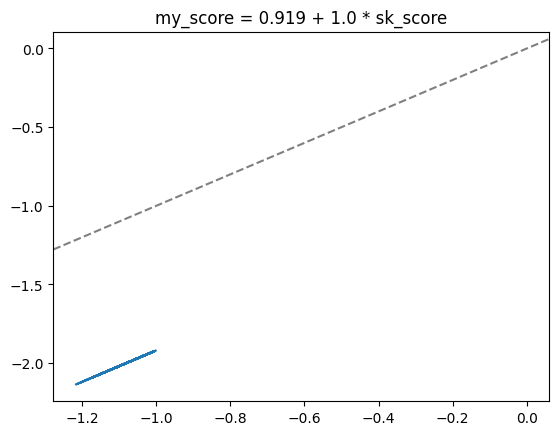

In [23]:
plt.plot(my_score, sk_score)
plt.axline([0, 0], slope=1, linestyle="dashed", color="gray")
est = LinearRegression().fit(X=sk_score.reshape(-1, 1), y=my_score)
plt.title(f"my_score = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * sk_score")
plt.show()


Efectivamente, la relación pareciera de identidad, salvo por una sospechosa constante $\approx2.757$. Hmmmm. Al menos, parecieran funcionar igual. Revisando la documentación de [`KernelDensity.score_samples`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html?highlight=kerneldensity#sklearn.neighbors.KernelDensity.score_samples), leo:

    Returns 
        density: ndarray of shape (n_samples,)

        Log-likelihood of each sample in X. These are normalized to be probability densities, so values will be low for high-dimensional data.

Y en el código fuente, se lee (editado):

```python
        N = self.tree_.data.shape[0]
        log_density = self.tree_.kernel_density(X, h=self.bandwidth, kernel=self.kernel)
        log_density -= np.log(N)
        return log_density
```

Veamos si podemos revertir esa "normalización" de `log_density -= np.log(N)`:


In [24]:
N = sk_kde.tree_.data.shape[0]
N, N == X.shape[0]


(100, False)

In [25]:
atol_N = sk_kde.atol * N
log_density = sk_kde.tree_.kernel_density(
    X,
    h=sk_kde.bandwidth,
    kernel=sk_kde.kernel,
    atol=atol_N,
    rtol=sk_kde.rtol,
    breadth_first=sk_kde.breadth_first,
    return_log=True,
)


ValueError: query data dimension must match training data dimension

In [26]:
assert np.allclose(sk_score + np.log(N), log_density)


ValueError: operands could not be broadcast together with shapes (100,) (150,) 

In [170]:
my_score[:5], log_density[:5]


(array([-2.15285911, -2.21996845, -2.21470712, -2.24684872, -2.16204292]),
 array([0.10096059, 0.03385124, 0.03911257, 0.00697097, 0.09177677]))

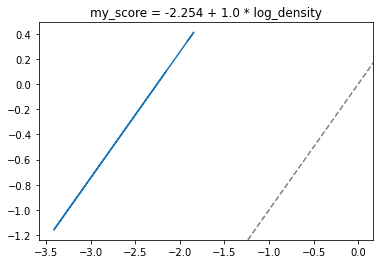

In [171]:
plt.plot(my_score, log_density)
plt.axline([0, 0], slope=1, linestyle="dashed", color="gray")
est = LinearRegression().fit(X=log_density.reshape(-1, 1), y=my_score)
plt.title(
    f"my_score = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * log_density"
)
plt.show()


El problema, es que esa desnormalización, no es del factor esperado:

In [172]:
np.log(N), LinearRegression().fit(X=sk_score.reshape(-1, 1), y=my_score).intercept_


(5.0106352940962555, 2.756815599614004)

Qué más hay de distinto? Habrán normalizado los datos sin avisar? La `data` (nuestra `X`) del estimador de densidad se accede desde `KernelDensity.tree_.data`, que es una `MemoryView` del array original.

In [173]:
sk_data = np.asarray(sk_kde.tree_.data)
assert np.all(sk_data == X)


No, tampoco es eso. Bueno, ya se verá. Por el momento, son funcionalmente idénticas las implementaciones, salvo por esa constante.

In [174]:
# TODO: review normalizing factors in BinaryTree.kernel_density
factor = 0.5 * d * np.log(2 * np.pi)
factor
# -factor - d * np.log(1)

3.6757541328186907

### Comparación de Performance

In [176]:
X_digits, _ = load_digits(return_X_y=True)

In [177]:
%%timeit
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits)

733 ns ± 28.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [178]:
%%timeit
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_digits)

7.95 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


`fit` es esencialmente "gratis", algunas pocas asignaciones en ambos casos.

In [179]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits)


In [180]:
%%timeit
my_kde.density(X_digits)

961 ms ± 83.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [181]:
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_digits)


In [182]:
%%timeit
sk_kde.score_samples(X_digits)

521 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [183]:
X_digits.shape


(1797, 64)

In [184]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_iris)


In [185]:
%%timeit
my_kde.density(X_iris)

1.84 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [186]:
sk_kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(X_iris)


In [187]:
%%timeit
sk_kde.score_samples(X_iris)

KeyboardInterrupt: 

In [ ]:
X_digits.shape, X_iris.shape


((1797, 64), (150, 4))

Los resultados para `my_kde`, por ejemplo:
```
digits: 1.44 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
iris:  2.23 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

In [ ]:
1440 / 2.23, 1797 / 150


(645.7399103139013, 11.98)

Ajustar `digits` toma 645 veces más tiempo que `iris`, con 12 veces más observaciones (pero claro, también 60 dimensiones más).


In [ ]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits)


In [ ]:
%%timeit
my_kde.density(X_digits)

1.03 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
my_kde.density(X_digits[:180])

91.8 ms ± 745 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Parece lineal en `n`.

In [ ]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits[:, :8])


In [ ]:
%%timeit
my_kde.density(X_digits[:,:8])

559 ms ± 363 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
my_kde = EuclideanKDE(kernel=32, bandwidth=1).fit(X_digits[:, :16])


In [ ]:
%%timeit
my_kde.density(X_digits[:,:16])

459 ms ± 9.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
my_kde = EuclideanKDE(kernel=norm_pdf, bandwidth=1).fit(X_digits[:, :32])


In [ ]:
%%timeit
my_kde.density(X_digits[:,:32])

659 ms ± 7.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
n_dims = np.linspace(8, 64, 8).astype(int)
runs = 4

In [ ]:
import time

In [ ]:
results = []
for n_dim in n_dims:
    X = X_digits[:, :n_dim]
    my_kde = EuclideanKDE().fit(X)
    for i in range(runs):
        t0 = time.time()
        my_kde.density(X)
        t = time.time() - t0
        results.append({"n_dim": n_dim, "run": i, "time": t})

In [ ]:
res = pd.DataFrame(results)

In [ ]:
import seaborn as sns

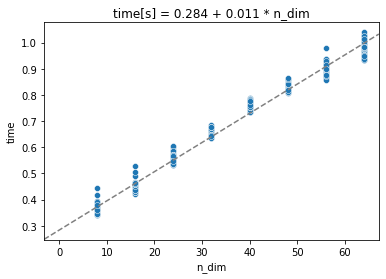

In [ ]:
sns.scatterplot(x="n_dim", y="time", data=res)
est = LinearRegression().fit(res[["n_dim"]], res.time)
plt.title(
    f"time[s] = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * n_dim"
)
plt.axline([0, est.intercept_], slope = est.coef_, linestyle="dashed", color="gray")
plt.show()

OK, también parece lineal en `n_dim`.

Los tiempos de `KernelDensity` son como la mitad de los de EuclideanKDE, pero no sé cuánto mejor/peor serían si implementase una DistanceMetric nueva para la distancia de Fermat. Por el momento, seguimos con la programacion habitual, y mantenemos los clasificadores de juguete.

In [188]:
from sklearn.model_selection import GridSearchCV

In [189]:
from numpy import random as rnd
import seaborn as sns


In [190]:
A = rnd.rand(100, 3)
A.sort(axis=1)
A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
a = A[0]
a, A[
    :5,
]


(array([0.        , 0.21462768, 0.53384619, 0.97290703, 1.        ]),
 array([[0.        , 0.21462768, 0.53384619, 0.97290703, 1.        ],
        [0.        , 0.08688388, 0.18767115, 0.49855838, 1.        ],
        [0.        , 0.10625519, 0.12141267, 0.58468375, 1.        ],
        [0.        , 0.24683507, 0.83066972, 0.94846913, 1.        ],
        [0.        , 0.09516656, 0.2350832 , 0.87213963, 1.        ]]))

In [191]:
def fermat_dist(x, alpha=1):
    """Fermat alpha-distance between `x_0` and `x_k`, in the line graph with nodes at `x = (x_1, ..., x_k)`."""
    return ((x[1:] - x[:-1]) ** alpha).sum()


In [192]:
np.apply_along_axis(fermat_dist, axis=1, arr=X, alpha=3).mean()


-49.56724

In [193]:
sample_size = 1000
scales = [1 / 10, 1 / 2, 1, 2, 10]
alphas = np.linspace(1, 4, 7)
ks = [1, 2, 5, 10]
results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for scale in scales:
        for alpha in alphas:
            results.append(
                dict(
                    k=k,
                    alpha=alpha,
                    scale=scale,
                    dists=np.apply_along_axis(
                        fermat_dist, axis=1, arr=scale * A, alpha=alpha
                    ),
                )
            )


In [194]:
df = pd.DataFrame(results)


In [195]:
df["mean_dist"] = df.dists.apply(np.mean)
df["scaled_dist"] = df.mean_dist / (df.scale**df.alpha)


In [196]:
df.head()


,k,alpha,scale,dists,mean_dist,scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000
1,1,1.5,0.1,"[0.02787101445310875, 0.029869087991085223, 0....",0.025368,0.802215
2,1,2.0,0.1,"[0.00813108524390552, 0.009167940375176223, 0....",0.006705,0.670466
3,1,2.5,0.1,"[0.0024119918267404296, 0.002830804114123916, ...",0.001823,0.576344
4,1,3.0,0.1,"[0.0007196627865858282, 0.0008751910562764335,...",0.000506,0.505699


In [197]:
df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)


scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,0.100,0.500,1.000,2.000,10.000
1.5,0.025,0.284,0.802,2.269,25.368
2.0,0.007,0.168,0.670,2.682,67.047
2.5,0.002,0.102,0.576,3.260,182.256
3.0,0.001,0.063,0.506,4.046,505.699
3.5,0.000,0.040,0.451,5.099,1425.204
4.0,0.000,0.025,0.407,6.506,4066.234


In [198]:
df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)


scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,1.000,1.000,1.000,1.000,1.000
1.5,0.802,0.802,0.802,0.802,0.802
2.0,0.670,0.670,0.670,0.670,0.670
2.5,0.576,0.576,0.576,0.576,0.576
3.0,0.506,0.506,0.506,0.506,0.506
3.5,0.451,0.451,0.451,0.451,0.451
4.0,0.407,0.407,0.407,0.407,0.407


Está claro que si $c$ es la constance de escale `scale`, las distancias de fermat escalan según $c^{-\alpha}$. Ahora, cuánto cambian con el tamaño de muestra $k$? 

Para $k=1$, se puede calcular exactamente la esperanza de la longitud del camino. Si hay un único punto entre 0 y 1 elegido al azar según $X \sim \text{Unif}(0, 1)$, entonces la longitud del camino de Fermat cuando $alpha=2$ será $E\left(X^2 + (1-X)^2\right) = 2/3$, lo cual se ve en la tabla anterior. Para $k=1$ y otros valores de $\alpha$, la expresión no será tan bella pero es computable sin mucha dificultad. Para otros valores de $k$, sin embargo, ya entran en juego la distribución de los estadísticos de orden y no me resulta para nada evidente una fórmula cerrada.

Aproximémosla. Sean $X^{(0)} = 0, X^{(k+1)} = 1$ y $X^{(i)}, i=1,\dots,k$ las v.a. que surgen de ordenar una muestra $X_i \sim_{iid} \text{Unif}(0, 1), \ i\in[k]$. Para todo $k$ se cumple que cada "segmentito de recta", $\mathbb{E}\left(X^{(i+1)}-X^{(i)}\right) = 1 / (k + 1)$. Luego, esperaríamos que 

$$
\begin{align} dist_{\alpha}^k(0, 1) &= \mathbb{E}\ \left(\sum_{i=0}^k \left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &=  \sum_{i=0}^k\ \left( \mathbb{E}\left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &\approx (???) (k + 1) \left(\frac{1}{k+1}\right)^{\alpha}
   \end{align}

$$

Pero no vale que $E(X^k) = E(X)^k$! Qué se hace en su lugar? Hay que conocer la densidad de $X^{(i+1)}-X^{(i)}$ y calcularlo? Empíricamente, veamos como cambia la distancia con $k$.

In [199]:
df[df.scale == 1].pivot("alpha", "k", "scaled_dist")


k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,0.802215,0.682784,0.506249,0.388933
2.0,0.670466,0.495449,0.278925,0.167652
2.5,0.576344,0.375539,0.163886,0.078223
3.0,0.505699,0.294128,0.101321,0.038900
3.5,0.450689,0.236310,0.065282,0.020397
4.0,0.406623,0.193769,0.043518,0.011188


In [200]:
df["k_scaled_dist"] = df.scaled_dist * ((df.k + 2) ** (df.alpha - 1))
df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")


k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,1.389477,1.365569,1.339410,1.347303
2.0,2.011397,1.981796,1.952474,2.011825
2.5,2.994773,3.004312,3.035216,3.251649
3.0,4.551288,4.706043,4.964748,5.601549
3.5,7.025549,7.561936,8.463233,10.174619
4.0,10.978832,12.401203,14.926826,19.332303


In [201]:
df


,k,alpha,scale,dists,mean_dist,scaled_dist,k_scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000,1.000000
1,1,1.5,0.1,"[0.02787101445310875, 0.029869087991085223, 0....",0.025368,0.802215,1.389477
2,1,2.0,0.1,"[0.00813108524390552, 0.009167940375176223, 0....",0.006705,0.670466,2.011397
3,1,2.5,0.1,"[0.0024119918267404296, 0.002830804114123916, ...",0.001823,0.576344,2.994773
4,1,3.0,0.1,"[0.0007196627865858282, 0.0008751910562764335,...",0.000506,0.505699,4.551288
...,...,...,...,...,...,...,...
135,10,2.0,10.0,"[11.992409614302325, 16.721204368885974, 17.73...",16.765204,0.167652,2.011825
136,10,2.5,10.0,"[13.808867528806926, 25.870266547138367, 26.90...",24.736131,0.078223,3.251649
137,10,3.0,10.0,"[16.235893617166735, 43.027516869766536, 42.69...",38.899649,0.038900,5.601549
138,10,3.5,10.0,"[19.391765603293933, 74.70707038947346, 69.637...",64.500789,0.020397,10.174619


In [202]:
sample_size = 1000
alphas = [1.5, 1.75, 2, 2.25, 3, 4, 5]
ks = np.array([*range(1, 11), *rnd.choice(range(11, 2001), 50, replace=False)])

results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for alpha in alphas:
        results.append(
            dict(
                k=k,
                alpha=alpha,
                dists=np.apply_along_axis(fermat_dist, axis=1, arr=A, alpha=alpha),
            )
        )

df = pd.DataFrame(results)
df["mean_dist"] = df.dists.apply(np.mean)


In [203]:
df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)


k,1,2,3,4,5,6,7,8,9,10
alpha,,,,,,,,,,
1.50,0.799,0.690,0.612,0.554,0.513,0.478,0.451,0.427,0.405,0.388
1.75,0.725,0.587,0.492,0.426,0.381,0.343,0.314,0.290,0.268,0.251
2.00,0.664,0.506,0.403,0.333,0.288,0.251,0.223,0.201,0.182,0.167
2.25,0.613,0.441,0.333,0.264,0.221,0.187,0.162,0.143,0.125,0.113
3.00,0.497,0.307,0.202,0.142,0.109,0.084,0.067,0.056,0.045,0.038
4.00,0.396,0.207,0.116,0.070,0.049,0.034,0.024,0.019,0.014,0.011
5.00,0.329,0.149,0.073,0.038,0.024,0.016,0.010,0.007,0.005,0.004


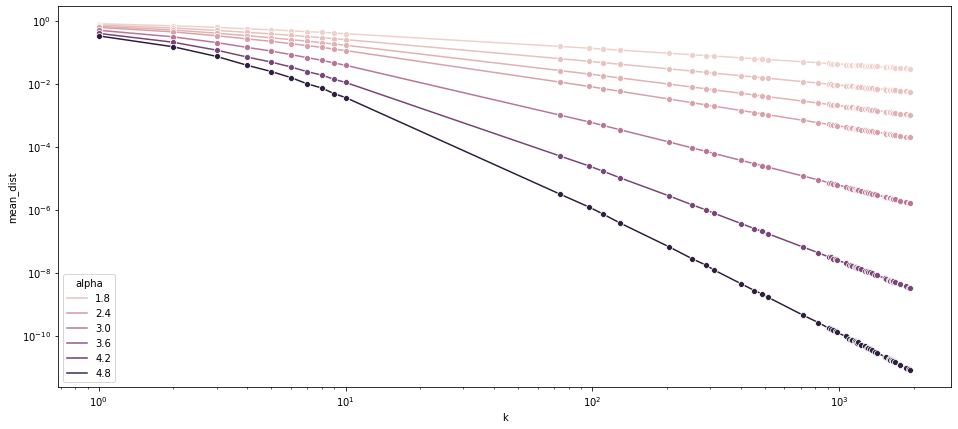

In [204]:
plt.figure(figsize=(16, 7))
sns.lineplot(x="k", y="mean_dist", hue="alpha", data=df, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.show()


Para la elección del ancho de banda $h$ es necesario saber la escala de las distancias! Con qué se come esto???

In [205]:
results = []
for i in range(10000):
    s = rnd.rand(100)
    s.sort()
    dists = (np.array([s[0], *(s[1:] - s[:-1]), 1 - s[-1]])) ** 2
    results.append((dists.mean(), dists.std()))


In [206]:
np.mean([std / mean for mean, std in results])


2.0492802385881217

## Implementación KDEClassifier

In [207]:
from scipy.stats import norm
from numpy.linalg import norm as euclidean_norm
from scipy.spatial import distance_matrix


In [208]:
import scipy

scipy.spatial.distance.minkowski(A[0], A[2])


0.4335707383019715

In [36]:
B = range(5)
C = range(7)
[[b * c for c in C] for b in B]


[[0, 0, 0, 0, 0, 0, 0],
 [0, 1, 2, 3, 4, 5, 6],
 [0, 2, 4, 6, 8, 10, 12],
 [0, 3, 6, 9, 12, 15, 18],
 [0, 4, 8, 12, 16, 20, 24]]

In [210]:
(A[:] == A[2]).all(1)[:5]


array([False, False,  True, False, False])

In [211]:
A.shape, np.zeros(10)


((1000, 99), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [212]:
# WIP - ignore
def euclidean_distance(x, y):
    return euclidean_norm(x - y)


class FermatDistance(Fermat):
    def __init__(self, **kwargs):
        super.__init__(**kwargs)

    def _fit(self, X):
        self.fit(X)
        self.X_ = X
        self.n_, self.d_ = X.shape
        self.is_fitted_ = True
        return self

    def __call__(A, B):
        if self.alpha == 1:
            return distance_matrix(A, B)
        else:
            return [[self._get_distance(a, b) for a in A] for b in B]

    def _get_distance(a, b):
        if not self.is_fitted_:
            self._fit()
        if any((self.X_[:] == a).all(1)):  # `a` is a node from X_
            to_X = np.zeros(self.n_)
        else:
            to_X = euclidean_distances(a.reshape(1, -1), verts)[0] ** self.alpha

        if a_known := np.where((X[:] == 2 * X[2]).all(1)):
            to_nodes = euclidean_distances(a.reshape(1, -1), verts)[0] ** alpha


In [213]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [73]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y  # , check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [74]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [75]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [76]:
A = np.array([[i] * 2 for i in range(3)])
Fermat(2, "FW").fit(distance_matrix(A, A)).get_distances()


array([[0., 2., 4.],
       [2., 0., 2.],
       [4., 2., 0.]])

In [77]:
B = np.vstack([[-1, 0], [1, 0]])
B


array([[-1,  0],
       [ 1,  0]])

In [78]:
C = np.vstack([A, B])


In [79]:
full = Fermat(2, "FW").fit(distance_matrix(C, C))
full_dists = full.get_distances()


In [80]:
n_train = 120
train = FermatKDE(2, "FW").fit(A)
test_dists = train.distances(B)


In [81]:
full_dists, test_dists


(array([[0., 2., 4., 1., 1.],
        [2., 0., 2., 3., 1.],
        [4., 2., 0., 5., 3.],
        [1., 3., 5., 0., 2.],
        [1., 1., 3., 2., 0.]]),
 array([[1., 3., 5.],
        [1., 1., 3.]]))

In [82]:
full = Fermat(2, "FW").fit(distance_matrix(X, X))
full_dists = full.get_distances()


In [83]:
n_train = 120
train = FermatKDE(2, "FW").fit(X[:n_train])
test_dists = train.distances(X[n_train:])


In [84]:
np.where(full_dists[n_train:, :n_train] > test_dists + 0.001)


(array([22]), array([101]))

In [85]:
full_dists[n_train:, :n_train][22, 101], test_dists[22, 101]


(0.1399999999999999, 0.0)

In [86]:
pd.Series((full_dists[n_train:, :n_train] - test_dists).flatten()).describe()


count    3.600000e+03
mean    -7.726667e-02
std      7.876425e-02
min     -4.600000e-01
25%     -1.200000e-01
50%     -6.000000e-02
75%     -4.440892e-16
max      1.400000e-01
dtype: float64

In [87]:
# Fermat distnaces between train obss, with X=train osbs, must be >= than
#   Fermat distances bw train obss, with X=(train obss + test obss)
assert (train.distances_ >= full_dists[:n_train, :n_train]).all()


```python
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())
```

In [88]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


0

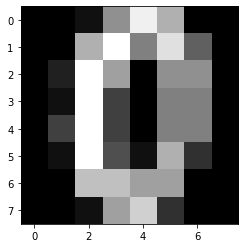

In [98]:
plt.imshow(X[10].reshape(8, 8), cmap="gray")
y[10]

In [110]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.80)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=200).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)


In [111]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(
    repr(rfclf2),
    " - enhanced: ",
    accuracy_score(
        rfclf2.predict(
            np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)
        ),
        y_test,
    ),
)


/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


EuclideanKDEClassifier() :  0.9575799721835884
FermatKDEClassifier(bandwith=200) :  0.96105702364395
RandomForestClassifier() :  0.9360222531293463
RandomForestClassifier()  - enhanced:  0.9443671766342142


In [112]:
accuracy_score(eucclf.predict(X_test), y_test), accuracy_score(
    fmtclf.predict(X_test), y_test
)


/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


(0.9575799721835884, 0.96105702364395)

In [124]:
X_digits, y_digits = load_digits(return_X_y=True)
n, d = X_digits.shape

In [132]:
fmt = Fermat(alpha=2, path_method="FW")
euc_dists = distance_matrix(X_digits, X_digits)
fmt.fit(euc_dists / (d))
fmt_dists = fmt.get_distances()

In [136]:
euc_dists[:5, :5] / d

array([[0.        , 0.93057337, 0.84577304, 0.74329687, 0.78654456],
       [0.93057337, 0.        , 0.65045807, 0.71055106, 0.74853372],
       [0.84577304, 0.65045807, 0.        , 0.84302631, 0.81400102],
       [0.74329687, 0.71055106, 0.84302631, 0.        , 0.800238  ],
       [0.78654456, 0.74853372, 0.81400102, 0.800238  , 0.        ]])

In [137]:
fmt_dists[:5, :5]

array([[0.        , 0.70874023, 0.62011719, 0.50756836, 0.54199219],
       [0.70874023, 0.        , 0.37231445, 0.50439453, 0.51391602],
       [0.62011719, 0.37231445, 0.        , 0.64379883, 0.64746094],
       [0.50756836, 0.50439453, 0.64379883, 0.        , 0.64038086],
       [0.54199219, 0.51391602, 0.64746094, 0.64038086, 0.        ]])

In [234]:
[x.shape for x in [X_train, X_test, y_train, y_test]]


[(179, 64), (1618, 64), (179,), (1618,)]

In [240]:
from scipy.special import softmax as sp_softmax
D = fmtclf.decision_function(X_test)
sp_softmax(D, axis=1).round(2)[:5]


array([[0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.92, 0.  , 0.  , 0.  , 0.08, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.36]])

In [241]:
(np.argmax(preds, axis=1) == y_test).mean()


NameError: name 'preds' is not defined

In [ ]:
X, y = load_iris(return_X_y=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases


In [ ]:
kde = KDEstimator()


In [ ]:
kde.fit(X[y == 0])


In [ ]:
kde.predict(X[-1])


0.00011495190242781194

In [ ]:
y[0]


0

## TemplateClassifier

In [277]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class TemplateClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, demo_param="demo"):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]


In [ ]:
unique_labels()


In [1]:
np.random.random()

NameError: name 'np' is not defined

In [188]:
import math
PI = math.pi
center = (0, 0)
inner_radius, outer_radius = 1, 1.5
sigma = 0.25
n_class = 500
n = n_class * 2
angles = np.random.rand(n) * 2 * PI

In [189]:
y = np.concatenate([np.zeros(n_class), np.ones(n_class)]).astype(int)
np.random.shuffle(y)
radii = np.where(y, outer_radius, inner_radius) + np.random.normal(scale=sigma, size=n)
X = np.array(
    [
        [radius * np.cos(angle), radius * np.sin(angle), 0, 0]
        for radius, angle in zip(radii, angles)
    ]
)


<AxesSubplot:>

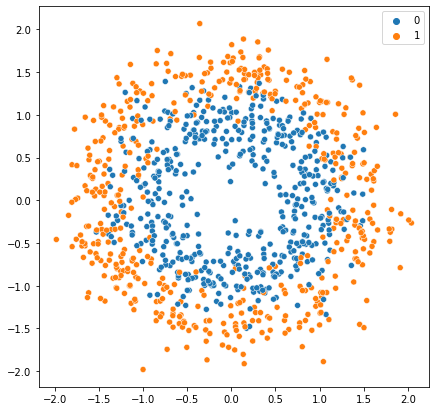

In [190]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [192]:
rfclf = RandomForestClassifier().fit(X_train, y_train)
accuracy_score(rfclf.predict(X_test), y_test)

0.836

In [193]:
eucclf = EuclideanKDEClassifier(bandwith=0.3).fit(X_train, y_train)
accuracy_score(eucclf.predict(X_test), y_test)

0.852

In [194]:
fmtclf = FermatKDEClassifier(bandwith=0.2, alpha=1.2).fit(X_train, y_train)
accuracy_score(fmtclf.predict(X_test), y_test)

0.852

In [356]:
np.logspace(-2, 1, 20)

array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])

In [195]:
grid = dict(bandwith=np.logspace(-2, 1, 30))

In [196]:
from sklearn.model_selection import GridSearchCV

In [197]:
eucclf = GridSearchCV(EuclideanKDEClassifier(), grid).fit(X_train, y_train)

/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/903982619.py:18: Run

In [198]:
accuracy_score(eucclf.predict(X_test), y_test)

0.856

In [199]:
eucclf.best_estimator_

EuclideanKDEClassifier(bandwith=0.3562247890262442,
                       kernel=<bound method rv_continuous.pdf of <scipy.stats._continuous_distns.norm_gen object at 0x7f4148c73df0>>)

In [201]:
grid = dict(alpha=[1.25, 1.5], bandwith=np.logspace(-2, 0, 10))

In [202]:
fmtclf = GridSearchCV(FermatKDEClassifier(), grid)

In [203]:
fmtclf.fit(X_train, y_train)

/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_72081/528438012.py:19: Run

GridSearchCV(estimator=FermatKDEClassifier(),
             param_grid={'alpha': [1.25, 1.5],
                         'bandwith': array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])})

In [204]:
accuracy_score(fmtclf.predict(X_test), y_test)

0.852

In [205]:
fmtclf.best_params_

{'alpha': 1.25, 'bandwith': 0.21544346900318834}

In [347]:
accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)

(0.87, 0.78)

In [348]:
accuracy_score(rfclf.predict(X_train), y_train), accuracy_score(rfclf.predict(X_test), y_test)

(1.0, 0.82)

In [349]:
accuracy_score(eucclf.predict(X_train), y_train), accuracy_score(eucclf.predict(X_test), y_test)

(0.88, 0.795)

In [350]:
eucclf = GridSearchCV(EuclideanKDEClassifier(), {"bandwith": np.logspace(-2, 0, 20)}).fit(X_train, y_train)
eucclf.best_params_

/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/3001414010.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/tmp/ipykernel_400884/30014

{'bandwith': 0.4832930238571752}

In [351]:
accuracy_score(eucclf.predict(X_test), y_test)

0.785

In [361]:
X.min(axis=0), X.max(axis=0)

(array([-3.04607482, -3.32174182]), array([3.30444116, 3.15130451]))

In [378]:
x = np.linspace(-4, 4, 50)
y = np.linspace(-4, 4, 50)

In [379]:
xx, yy = np.meshgrid(x, y)

In [381]:
rcclf.predict()

(50, 50)

In [394]:
rfpred = rfclf.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))

<AxesSubplot:>

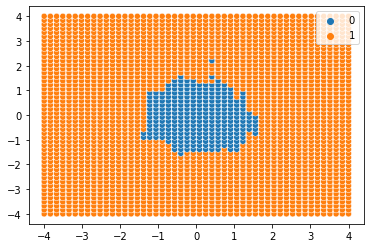

In [395]:
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=rfpred)

In [396]:
fmtpred = clf.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<AxesSubplot:>

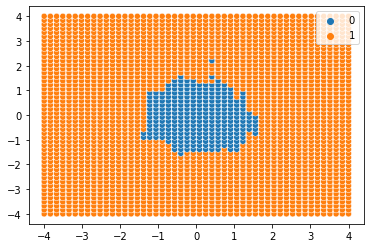

In [ ]:
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=rfpred)

array([[-9.07725789e-02, -1.82886602e-02, -1.23862462e-02],
       [-2.64253342e-02, -3.78069118e-02, -3.06195116e-02],
       [ 2.43678494e-02, -3.01132875e-02,  6.87818769e-03],
       [ 2.76952903e-02,  1.16056763e-02, -5.64777449e-02],
       [ 6.00989414e-02,  1.93943529e-02, -7.21929901e-02],
       [ 2.47786622e-02,  1.01444912e-01,  2.77091171e-02],
       [-2.07316300e-02, -2.23787407e-02, -2.82159874e-02],
       [-1.02354243e-03,  5.08288458e-02, -2.16049816e-02],
       [ 2.13143694e-02,  5.94537012e-02, -3.93601742e-02],
       [ 4.86531929e-05, -4.32023088e-03,  5.14577161e-02],
       [ 1.25324345e-01, -4.23054579e-03, -3.84843914e-03],
       [ 6.09188697e-02, -4.94266568e-02,  8.54143414e-03],
       [ 6.65971061e-02, -4.94756437e-03, -5.03286970e-03],
       [ 6.10418139e-02,  4.45921132e-02,  2.27508052e-02],
       [ 1.54154241e-02,  6.95667995e-02,  6.45182341e-02],
       [ 1.07328084e-03, -2.73757357e-02,  1.45994017e-02],
       [ 6.70059487e-03, -8.25942253e-02

In [268]:
def trefoil(n, start=0, noise_dims=37, end=2*PI):
    T = start + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [
            [np.sin(t), np.cos(t) - 2 * np.cos(2*t), -np.sin(3*t)]
            for t in T
        ]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)

In [269]:
X_trefA = trefoil(200)

In [270]:
X_trefB = trefoil(200)

In [271]:
X_trefB[:, [0, 1, 2]] = X_trefB[:, [1, 2, 0]]

In [272]:
X_tref = np.concatenate([X_trefA, X_trefB], axis=0)

In [273]:
y_tref = np.concatenate([np.zeros(200), np.ones(200)], axis=0)

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X_tref, y_tref, test_size=0.80)

In [282]:
rfclf = RandomForestClassifier().fit(X_train, y_train)
accuracy_score(rfclf.predict(X_test), y_test)

0.7125

In [283]:
eucclf = EuclideanKDEClassifier(bandwith=0.3).fit(X_train, y_train)
accuracy_score(eucclf.predict(X_test), y_test)

0.934375

In [285]:
fmtclf = FermatKDEClassifier(bandwith=0.2, alpha=1.2).fit(X_train, y_train)
accuracy_score(fmtclf.predict(X_test), y_test)

0.93125